In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Creating a SQL connection to our SQLite database
con = sqlite3.connect("../FPA_FOD_20210617.sqlite")

In [3]:
# Region dictionary
region_dict = {
    101:'Northeast Climate Region',
    102:'Upper Midwest Climate Region',
    103:'Ohio Valley Climate Region',
    104:'Southeast Climate Region',
    105:'Northern Rockies and Plains Climate Region',
    106:'South Climate Region',
    107:'Southwest Climate Region',
    108:'Northwest Climate Region',
    109:'West Climate Region'
}

In [4]:
# Querying the region_id, Discovery_date, FPA_ID from our "Fires" table
fire_data = pd.read_sql('SELECT region_id, DISCOVERY_DATE, FPA_ID FROM Fires', con).dropna()

In [5]:
# Printing the DataFrame
fire_data.head()

,region_id,DISCOVERY_DATE,FPA_ID
0,109.0,2/2/2005 0:00,FS-1418826
1,109.0,5/12/2004 0:00,FS-1418827
2,109.0,5/31/2004 0:00,FS-1418835
3,109.0,6/28/2004 0:00,FS-1418845
4,109.0,6/28/2004 0:00,FS-1418847


In [6]:
# Converting the "DISCOVERY_DATE" column to datetime
fire_data['DISCOVERY_DATE'] = pd.to_datetime(fire_data['DISCOVERY_DATE'])
fire_data.head()

,region_id,DISCOVERY_DATE,FPA_ID
0,109.0,2005-02-02,FS-1418826
1,109.0,2004-05-12,FS-1418827
2,109.0,2004-05-31,FS-1418835
3,109.0,2004-06-28,FS-1418845
4,109.0,2004-06-28,FS-1418847


In [7]:
# Casting the "DISCOVERY_DATE" to a datetime array - Months
# Counting the number of fires per region and discovery date
# Printing new DataFrame
period = fire_data.DISCOVERY_DATE.dt.to_period("M")
fire_data = fire_data.groupby([period, 'region_id']).count()
fire_data.head()

DISCOVERY_DATE  FPA_ID
DISCOVERY_DATE region_id                        
1992-01        101.0                  86      86
               102.0                   4       4
               103.0                 119     119
               104.0                2609    2609
               105.0                  86      86

In [8]:
# Renaming our "DISCOVERY_DATE" column
# Resetting the index
# Printing the updated DataFrame
fire_data.rename(columns={'DISCOVERY_DATE': 'Count'}, inplace=True)
fire_data = fire_data.reset_index()
fire_data.head()

,DISCOVERY_DATE,region_id,Count,FPA_ID
0,1992-01,101.0,86,86
1,1992-01,102.0,4,4
2,1992-01,103.0,119,119
3,1992-01,104.0,2609,2609
4,1992-01,105.0,86,86


In [9]:
# Adding a "Month" column
# Renaming our "DISCOVERY_DATE" column
# Printing the updated DataFrame
fire_data['Month'] = fire_data.iloc[:,0].dt.strftime('%m')
fire_data.rename(columns={'DISCOVERY_DATE':'Date'}, inplace=True)
fire_data.head()

,Date,region_id,Count,FPA_ID,Month
0,1992-01,101.0,86,86,01
1,1992-01,102.0,4,4,01
2,1992-01,103.0,119,119,01
3,1992-01,104.0,2609,2609,01
4,1992-01,105.0,86,86,01


In [10]:
# Renaming my "region_id" column
# Printing updated DataFrame
fire_data.rename(columns={'region_id': 'Region_id'}, inplace=True)
fire_data.head()

,Date,Region_id,Count,FPA_ID,Month
0,1992-01,101.0,86,86,01
1,1992-01,102.0,4,4,01
2,1992-01,103.0,119,119,01
3,1992-01,104.0,2609,2609,01
4,1992-01,105.0,86,86,01


In [11]:
# Querying the minimum temperatures, maximum temperatures and precipitation values from our Database and storing these into a DataFrame
weather_data = pd.read_sql('SELECT region_id, date, min_temp, max_temp,precipitation from weather', con).dropna()

In [12]:
# Converting the "date" column to datetime
# Printing the updated DataFrame
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.to_period("M")
weather_data.head()

,region_id,date,min_temp,max_temp,precipitation
0,101,1992-01,14.6,32.5,2.47
1,101,1992-02,16.5,34.9,2.22
2,101,1992-03,20.2,39.8,3.70
3,101,1992-04,32.8,53.1,2.74
4,101,1992-05,41.8,67.4,2.77


In [13]:
# Renaming my columns
# Printing updated DataFrame
weather_data.rename(columns={'region_id': 'Region_id'}, inplace=True)
weather_data.rename(columns={'date': 'Date'}, inplace=True)
weather_data.rename(columns={'min_temp': 'Min_temp'}, inplace=True)
weather_data.rename(columns={'max_temp': 'Max_temp'}, inplace=True)
weather_data.rename(columns={'precipitation': 'Precipitation'}, inplace=True)
weather_data.head()

,Region_id,Date,Min_temp,Max_temp,Precipitation
0,101,1992-01,14.6,32.5,2.47
1,101,1992-02,16.5,34.9,2.22
2,101,1992-03,20.2,39.8,3.70
3,101,1992-04,32.8,53.1,2.74
4,101,1992-05,41.8,67.4,2.77


In [14]:
# Merging the Fires and Weather tables
# Printing new DataFrame
merged_data = weather_data.merge(fire_data, how="left", on=["Date","Region_id"]).fillna(0)
merged_data.head()

,Region_id,Date,Min_temp,Max_temp,Precipitation,Count,FPA_ID,Month
0,101,1992-01,14.6,32.5,2.47,86.0,86.0,01
1,101,1992-02,16.5,34.9,2.22,130.0,130.0,02
2,101,1992-03,20.2,39.8,3.70,283.0,283.0,03
3,101,1992-04,32.8,53.1,2.74,743.0,743.0,04
4,101,1992-05,41.8,67.4,2.77,830.0,830.0,05


In [15]:
merged_data.isna().sum()

Region_id        0
Date             0
Min_temp         0
Max_temp         0
Precipitation    0
Count            0
FPA_ID           0
Month            0
dtype: int64

In [16]:
# Casting the "Region_id", "Count" and "Month" columns into floats
merged_data = merged_data.astype({'Region_id':float,'Count':float,'Month':float})

### Machine Learning

In [17]:
# Assigning the data to X and y
X = merged_data[["Min_temp", "Max_temp", "Precipitation", "Region_id"]]
y = merged_data["Count"].values.reshape(-1, 1)
print(X.shape, y.shape)

(2817, 4) (2817, 1)


In [18]:
# Printing the y values
print(y)

[[ 86.]
 [130.]
 [283.]
 ...
 [359.]
 [445.]
 [241.]]


In [19]:
# Putting the X values into a DataFrame called "features_df"
# Printing DataFrame
features_df = pd.DataFrame(X)
features_df.head()

,Min_temp,Max_temp,Precipitation,Region_id
0,14.6,32.5,2.47,101.0
1,16.5,34.9,2.22,101.0
2,20.2,39.8,3.70,101.0
3,32.8,53.1,2.74,101.0
4,41.8,67.4,2.77,101.0


array([[<AxesSubplot:title={'center':'Min_temp'}>,
        <AxesSubplot:title={'center':'Max_temp'}>],
       [<AxesSubplot:title={'center':'Precipitation'}>,
        <AxesSubplot:title={'center':'Region_id'}>]], dtype=object)

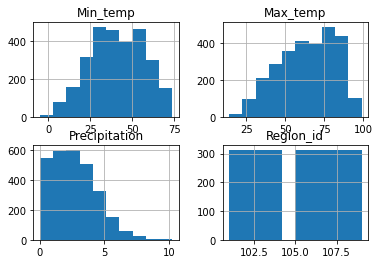

In [20]:
# Plotting all Values included in features_df
features_df.hist(bins=10)

In [21]:
# Putting the y values into a DataFrame called "labels_df"
# Printing DataFrame
labels_df = pd.DataFrame(y)
labels_df.head()

,0
0,86.0
1,130.0
2,283.0
3,743.0
4,830.0


In [22]:
# Merging the features_df and labels_df DataFrames
# Renaming the "0" column to "Count"
# Printing the new DataFrame
df = pd.concat([features_df, labels_df], axis=1)
df.rename(columns={0: 'Count'}, inplace=True)
df.head()

,Min_temp,Max_temp,Precipitation,Region_id,Count
0,14.6,32.5,2.47,101.0,86.0
1,16.5,34.9,2.22,101.0,130.0
2,20.2,39.8,3.70,101.0,283.0
3,32.8,53.1,2.74,101.0,743.0
4,41.8,67.4,2.77,101.0,830.0


In [23]:
# Calculating the mean, median, trim_mean and the np.quantile of the Precipitation
print(df["Precipitation"].mean())
print(df["Precipitation"].median())
print(stats.trim_mean(df["Precipitation"],0.1))
print(np.quantile(df["Precipitation"],0.98))

2.710649627263044
2.52
2.584274944567628
6.6899999999999995


In [24]:
# Identifying the maximum value
print(df["Precipitation"].max())

10.27


In [25]:
# Removing outliers
Precipitation_95 = np.quantile(df["Precipitation"],0.95)
df_Nooutlier = df[df["Precipitation"] <= Precipitation_95]

In [26]:
# Removing outliers
Count_90 = np.quantile(df_Nooutlier["Count"],0.90)
df_Nooutlier = df_Nooutlier[df_Nooutlier["Count"] <= Count_90]

array([[<AxesSubplot:title={'center':'Min_temp'}>,
        <AxesSubplot:title={'center':'Max_temp'}>],
       [<AxesSubplot:title={'center':'Precipitation'}>,
        <AxesSubplot:title={'center':'Region_id'}>],
       [<AxesSubplot:title={'center':'Count'}>, <AxesSubplot:>]],
      dtype=object)

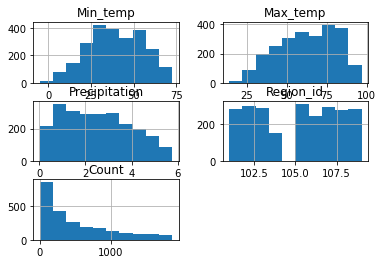

In [27]:
df_Nooutlier.hist(bins=10)

In [28]:
# Assigning the data to X and with our combined DataFrame
X = df_Nooutlier[["Min_temp", "Max_temp", "Precipitation", "Region_id"]]
y = df_Nooutlier["Count"].values.reshape(-1, 1)
print(X.shape, y.shape)

(2408, 4) (2408, 1)


In [29]:
# Using train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=1
)

In [30]:
# Removing the "Region_id" column to use only the "Min_temp", "Max_temp" and "Precipitation" in my model
# Using the loc function to do this
X_train2 = X_train.iloc[:,0:3]
X_test2 = X_test.iloc[:,0:3]

In [31]:
# Printing the new "X_train2" to ensure that "Region_id" has been removed
X_train2

,Min_temp,Max_temp,Precipitation
1509,49.6,75.8,2.58
1922,51.0,79.6,1.66
2297,22.8,38.7,2.08
614,18.9,38.1,1.29
695,43.4,67.2,2.28
...,...,...,...
1175,63.1,83.6,5.51
1070,34.8,56.1,5.32
1336,10.4,30.4,0.99
262,27.0,44.9,3.71


In [32]:
# Standardization
sc = StandardScaler()

X_train2 = sc.fit_transform(X_train2)

In [33]:
# Creating the Linear Regression model
regression_model = LinearRegression()

regression_model.fit(X_train2, y_train)

LinearRegression()

In [34]:
# Calculating the coefficient for our three variables
for idx, col_name in enumerate(pd.DataFrame(X_train2).columns):

    print(
        "The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx])
    )

The coefficient for 0 is -688.258080180941
The coefficient for 1 is 930.2032256052585
The coefficient for 2 is 24.345822030097196


In [35]:
# Calculating the model intercept
intercept = regression_model.intercept_[0]

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 502.4158878504672


In [36]:
regression_model.score(X_train2, y_train)

0.3516753851918615

In [37]:
# Creating function to determine the RMSE, MAE and R-squared metrics to evaluate the prediction error rates and model performance. 
def adj_r2_score(predictors, targets, predictions):

    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100
def model_performance_regression(model, predictors, target):
    pred = model.predict(predictors)
    r2 = r2_score(target, pred)
    adjr2 = adj_r2_score(predictors, target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    mape = mape_score(target, pred)
    df2 = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            # "MAPE": mape,
        },
        index=[0],
    )
    return df2

In [38]:
# Calculating the RMSE, MAE, R-squared and the Adj.R-squared
lin_reg_model_train_perf = model_performance_regression(

    regression_model, X_train2, y_train
)
lin_reg_model_train_perf

<ipython-input-37-cd7ec3985496>:9: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(targets - predictions) / targets) * 100


,RMSE,MAE,R-squared,Adj. R-squared
0,396.617588,304.347687,0.351675,0.350663


In [39]:
# Printing our predicted values
X_test2 = sc.transform(X_test2)

y_test_pred = regression_model.predict(X_test2)
y_test_pred

array([[ 3.41428376e+02],
       [ 7.09862492e+02],
       [ 9.99188825e+02],
       [ 3.90405401e+02],
       [-3.04562540e-01],
       [ 9.19123543e+02],
       [ 5.99185935e+02],
       [ 6.17313849e+02],
       [ 6.28523355e+02],
       [ 6.55149621e+02],
       [ 2.92945582e+02],
       [ 1.76039894e+02],
       [ 1.27587713e+02],
       [ 6.36138889e+02],
       [ 6.60699060e+02],
       [ 6.81317573e+02],
       [ 5.85658560e+01],
       [ 7.57521639e+02],
       [ 1.39213537e+02],
       [ 9.60658930e+02],
       [ 3.30012441e+02],
       [-8.76800389e+01],
       [ 8.34487136e+02],
       [ 9.03862911e+02],
       [ 9.75624888e+02],
       [ 5.68978727e+02],
       [ 3.55548897e+02],
       [ 8.15715519e+02],
       [ 9.53085847e+02],
       [ 6.48200262e+02],
       [ 1.40580253e+02],
       [ 5.69116448e+02],
       [ 6.88683249e+02],
       [ 6.48142708e+02],
       [ 6.26838224e+02],
       [ 2.71268847e+02],
       [ 2.80469962e+02],
       [ 4.99875088e+02],
       [ 5.0

In [40]:
# Creating a new variable "id" that will hold the "Region_id" values
id = X_test["Region_id"]
id

2816    109.0
2759    109.0
2605    109.0
1864    106.0
1468    105.0
        ...  
1674    106.0
854     103.0
1531    105.0
1474    105.0
2574    109.0
Name: Region_id, Length: 482, dtype: float64

In [41]:
# Converting "id" into a DataFrame
# Resetting the index
# Printing the DataFrame
id1 = pd.DataFrame(id)
id1.reset_index(drop=True, inplace=True)
id1.head()

,Region_id
0,109.0
1,109.0
2,109.0
3,106.0
4,105.0


In [42]:
# Converting "y_test_pred1" into a DataFrame
# Resetting the index
# Renaming my column
# Printing the DataFrame
y_test_pred1 = pd.DataFrame(y_test_pred)
y_test_pred1.reset_index(drop=True, inplace=True)
y_test_pred1.rename(columns={0 : 'Predicted_Values'}, inplace=True)
y_test_pred1.head()

,Predicted_Values
0,341.428376
1,709.862492
2,999.188825
3,390.405401
4,-0.304563


In [43]:
# Converting "y_test1" into a DataFrame
# Resetting the index
# Renaming my column
# Printing the DataFrame
y_test1 = pd.DataFrame(y_test)
y_test1.reset_index(drop=True, inplace=True)
y_test1.rename(columns={0 : 'Actual_Values'}, inplace=True)
y_test1.head()

,Actual_Values
0,241.0
1,669.0
2,1419.0
3,1066.0
4,22.0


In [44]:
# Creating a new DataFrame that will contain the values needed
predictions = pd.concat([id1, y_test_pred1, y_test1], axis=1)
predictions.head()

,Region_id,Predicted_Values,Actual_Values
0,109.0,341.428376,241.0
1,109.0,709.862492,669.0
2,109.0,999.188825,1419.0
3,106.0,390.405401,1066.0
4,105.0,-0.304563,22.0


In [45]:
# Sorting my DataFrame by "Region_id"
predictions = predictions.sort_values(by=['Region_id'])

In [46]:
# Resetting the index
predictions.reset_index(drop=True, inplace=True)

In [47]:
# Printing the DataFrame
predictions.head()

,Region_id,Predicted_Values,Actual_Values
0,101.0,180.873234,709.0
1,101.0,393.149619,370.0
2,101.0,634.512776,303.0
3,101.0,605.385351,461.0
4,101.0,83.188122,405.0


In [48]:
# Exporting my "predictions" DataFrame into a CSV file
predictions.to_csv("predictions_output.csv", mode = 'w', index=False)